# Look at ENSO metric sensitivity to sample size, using CESM1/2

In [1]:
import os
import glob
import numpy as np 
import xarray as xr
import pandas as pd
import datetime
from datetime import date, timedelta
import dask
import re
import scipy.stats as stats
import scipy.signal as signal
from skimage.measure import find_contours
from statsmodels.tsa.stattools import acf, pacf

import isla_interp_utils as isla_interp

# Plotting utils 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import cartopy
import cartopy.crs as ccrs
import seaborn as sns


In [2]:
def regrid_data(fromthis, tothis, method=1):
    """Regrid data using various different methods"""

    #Import necessary modules:
    import xarray as xr

    if method == 1:
        # kludgy: spatial regridding only, seems like can't automatically deal with time
        if 'time' in fromthis.coords:
            result = [fromthis.isel(time=t).interp_like(tothis) for t,time in enumerate(fromthis['time'])]
            result = xr.concat(result, 'time')
            return result
        else:
            return fromthis.interp_like(tothis)
    elif method == 2:
        newlat = tothis['lat']
        newlon = tothis['lon']
        coords = dict(fromthis.coords)
        coords['lat'] = newlat
        coords['lon'] = newlon
        return fromthis.interp(coords)
    elif method == 3:
        newlat = tothis['lat']
        newlon = tothis['lon']
        ds_out = xr.Dataset({'lat': newlat, 'lon': newlon})
        regridder = xe.Regridder(fromthis, ds_out, 'bilinear')
        return regridder(fromthis)
    elif method==4:
        # geocat
        newlat = tothis['lat']
        newlon = tothis['lon']
        result = geocat.comp.linint2(fromthis, newlon, newlat, False)
        result.name = fromthis.name
        
        return result

# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

# - - - - - - - - - - - - - - - 
# Pre-process data while reading in 
# - - - - - - - - - - - - - - - 

def preprocess(ds):
    dsCorr         = cesm_correct_time(ds)
    dsCorr         = dsCorr.sel(lat=slice(-10,10))
    
    return dsCorr

## Calculate nino anomalies 
def rmMonAnnCyc(DS): 
    
    climatology = DS.groupby("time.month").mean("time")
    anomalies   = DS.groupby("time.month") - climatology    

    return anomalies

def getLagCorr(lag, nino34, corDS):

    if lag>0: 
        A  = nino34[:-lag]
        # B  = sst_anom.isel(case=iCase).shift(time=lag).isel(time=slice(lag,len(sst_anom.time.values)))
        # B['time'] = sst_anom.time.values[:-lag]  # To get xr.corr to work, need to have the "same" time for computing corrs
        B  = corDS.shift(time=-lag).isel(time=slice(0,len(corDS.time.values)-lag))
        B['time'] = corDS.time.values[:-lag]  # To get xr.corr to work, need to have the "same" time for computing corrs
    elif lag<0:
        A  = nino34[-lag:]
        A['time'] = nino34.time.values[:lag]
        B  = corDS.isel(time=slice(0,len(corDS.time.values)+lag))
    elif lag==0:
        A = nino34
        B = corDS
            
    cor = xr.corr(A, B, dim="time")

    return cor

def getWesternPoint(DS, contourLev):
    corrs_sel = DS.sel(lon=slice(120,240), lat=slice(-10,10))
    c2 = plt.contour(corrs_sel.lon.values,corrs_sel.lat.values ,  corrs_sel, [contourLev], transform=ccrs.PlateCarree())
    
    # Add contour marker
    maybeLon = []
    maybeLat = []
    lenSeg = 0
    for iSegs in range(len(c2.allsegs[0])): 
        dat0 = c2.allsegs[0][iSegs]
        western_most_lon = np.nanmin(dat0[:,0])
        iMatchLat = np.where(dat0[:,0]==western_most_lon)[0]
        maybeLon = np.append(maybeLon, western_most_lon)
        maybeLat = np.append(maybeLat, dat0[int(iMatchLat[0]),1])
        if len(dat0)>lenSeg:
            lenSeg= len(dat0)
            iselSeg = iSegs
    
    # axs.plot(maybeLon[iselSeg], maybeLat[iselSeg], 'o', color='limegreen', markersize=5, transform=ccrs.PlateCarree() )
    
    return maybeLon[iselSeg],maybeLat[iselSeg]

## Set up dask?

In [3]:
import dask
dask.config.set({'logging.distributed': 'error'})

from dask_jobqueue import PBSCluster

# For Casper
cluster = PBSCluster(
    queue="casper",
    walltime="03:00:00",
    account="P93300041",
    memory="8GB",
    resource_spec="select=1:ncpus=1:mem=8GB",
    cores=1,
    processes=1,
)

from dask.distributed import Client

# Connect client to the remote dask workers
client = Client(cluster)
client

cluster.scale(28)
client.wait_for_workers(28)
# cluster.scale(8)
# client.wait_for_workers(8)


/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38365 instead
  warnings.warn(


In [4]:
client

<Client: 'tcp://128.117.208.174:40523' processes=11 threads=11, memory=81.95 GiB>

## Read in data

In [5]:
cesm2_dir = '/glade/campaign/collections/cdg/data/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/ts/gn/files/d20190320/'
cesm1_dir = '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/TS/'

listFiles_cesm1 = np.sort(glob.glob(cesm1_dir+'b.e11.B1850C5CN.f09_g16.005.cam.h0.TS.*nc'))
listFiles_cesm2 = np.sort(glob.glob(cesm2_dir+'ts_Amon_CESM2_piControl_r1i1p1f1_gn*.nc'))

DS_all_cesm1 = xr.open_mfdataset(listFiles_cesm1, preprocess=preprocess, concat_dim='time', combine='nested', 
                                 decode_times=False, data_vars='minimal', parallel=True)

DS_all_cesm2 = xr.open_mfdataset(listFiles_cesm2, 
                                 preprocess=preprocess, concat_dim='time', combine='nested', 
                                 decode_times=False, data_vars='minimal', parallel=True)


In [6]:
nYears_cesm1 = len(DS_all_cesm1.time.values)/12
nYears_cesm2 = len(DS_all_cesm2.time.values)/12
print('CESM1 has %i years.\nCESM2 has %i years.' % (nYears_cesm1,nYears_cesm2) )


CESM1 has 1801 years.
CESM2 has 1200 years.


## Compute metrics over various slices

In [7]:
## Some basics - the region to focus on, for one
lat_n = 10.0
lat_s = -10.0

# Nino3.4
lat_n34 = 5
lat_s34 = -5
lon_e34 = 190 
lon_w34 = 240

# Nino3
lat_n3 = 5
lat_s3 = -5
lon_e3 = 210 
lon_w3 = 270

# Nino 4
lat_n4 = 5
lat_s4 = -5
lon_e4 = 160 
lon_w4 = 210

# Nino 1+2
lat_n12 = 0
lat_s12 = -10
lon_e12 = 270 
lon_w12 = 280

#                          J   F   M    A  M   J   J   A    S   O    N  D
daysPerMonth = np.asarray([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])



In [8]:
## Get ocean mask
testFile = '/glade/derecho/scratch/mdfowler/enso_wavelet/b.e23_alpha16g.BLT1850.ne30_t232.075.cam.h0.TS.1-125.10.N-10.S.nc'
DS_ocn = xr.open_dataset(testFile) 

# Updating limit of ocnfrac used to determine mask
# ocnMask = DS_ocn.LANDFRAC.isel(time=slice(0, len(DS_cesm1_events.time.values))).values
ocnMask = DS_ocn.LANDFRAC.isel(time=1).values
ocnMask[ocnMask>0.45]  = np.nan
ocnMask[ocnMask<=0.45] = 1

# # Add the new 'event' dimension using numpy.expand_dims
# ocnMask_expanded1 = np.expand_dims(ocnMask, axis=0)  # Add the new dimension at the front (axis=0)

# # Now, tile or repeat the array to match the desired number of events
# ocnMask_expanded1 = np.tile(ocnMask_expanded1, (len(DS_cesm1_events.time.values), 1, 1))

# ocnMask_expanded = np.expand_dims(ocnMask_expanded1, axis=0)  # Add the new dimension at the front (axis=0)
# ocnMask_expanded = np.tile(ocnMask_expanded, (len(DS_cesm1_events.event.values), 1, 1, 1))


In [12]:
def get_ninoMetrics(DS, time_coords, lat, lon ):
    # Detrend data 
    TS = DS
    ts = signal.detrend(TS, axis=0, type='linear')
    # Get SST 
    sst = ts * ocnMask
    sst_raw_data = TS * ocnMask
    
    sst = xr.DataArray(sst, 
        coords={'time': time_coords,
                'lat':  lat, 
                'lon':  lon}, 
        dims=["time", "lat", "lon"])
    
    
    # Remove annual cycle from monthly data 
    sst_anom = rmMonAnnCyc(sst)
    
    ## Compute nino 3.4 index
    ## - - - - - - - - - - - - 
    ilats = np.where((sst_anom.lat.values>=lat_s34)  & (sst_anom.lat.values<=lat_n34))[0]
    ilons = np.where((sst_anom.lon.values>=lon_e34)  & (sst_anom.lon.values<=lon_w34))[0]
    
    regionTS = sst_anom.isel(lat=ilats, lon=ilons)
    coswgt   = np.cos(np.deg2rad(regionTS.lat))
    nino34   = regionTS.weighted(coswgt).mean(('lon','lat'))
    del ilats,ilons

    ## Western extent of SST correlation 
    ## - - - - - - - - - - - - - - - - - -
    
    cor_case       = getLagCorr(0, nino34, sst_anom)
    
    ## Figure out western-most longitude of zero contour in pacific 
    #     This works by creating a plot with a contour and identifying the western point, but I'm closing that plot
    fig,axs = plt.subplots(1,1,figsize=(20,7),subplot_kw={"projection":ccrs.PlateCarree(central_longitude=210)})
    
    lon0, lat0     = getWesternPoint(cor_case, 0)
    lon0p5, lat0p5 = getWesternPoint(cor_case, 0.5)

    plt.close()

    ## Variance and Auto-correlation
    ## - - - - - - - - - - - - - - - - 
    
    # nino34_var    = np.full([12], np.nan)
    nino34_ac     = np.full([48], np.nan)
    transit_month = np.nan

    nino34_var = nino34.groupby('time.month').var()
    nino34_pd  = pd.Series(nino34.values)

    for iLag in range(48):
        nino34_ac[iLag] = nino34_pd.autocorr(lag=iLag)
        ## Updating to interpolate rather than take an integer!
        if ((nino34_ac[iLag-1]>0) & (nino34_ac[iLag]<0) & (np.isfinite(transit_month)==False)):
            # transit_month = iLag-1
            y0 = 0
            x =([iLag-1,iLag])
            y = [nino34_ac[iLag-1], nino34_ac[iLag]]
            x1 = iLag-1
            x2 = iLag
            y1 = nino34_ac[iLag-1]
            y2 = nino34_ac[iLag]
            
            transit_month = (y0 - y1) / (y2 - y1) * (x2 - x1) + x1


    return lon0, lat0, lon0p5, lat0p5, nino34_var, nino34_ac, transit_month
    

    

Creating 60 samples to compute ENSO over, starting every 20 years and each with a window of 20 years.
Creating 40 samples to compute ENSO over, starting every 30 years and each with a window of 30 years.
Creating 30 samples to compute ENSO over, starting every 40 years and each with a window of 40 years.
Creating 24 samples to compute ENSO over, starting every 50 years and each with a window of 50 years.
Creating 16 samples to compute ENSO over, starting every 75 years and each with a window of 75 years.
Creating 12 samples to compute ENSO over, starting every 100 years and each with a window of 100 years.
Creating 9 samples to compute ENSO over, starting every 125 years and each with a window of 125 years.
Creating 8 samples to compute ENSO over, starting every 150 years and each with a window of 150 years.
Creating 6 samples to compute ENSO over, starting every 200 years and each with a window of 200 years.
Creating 4 samples to compute ENSO over, starting every 250 years and each wi

Text(0, 0.5, 'Variance (K**2)')

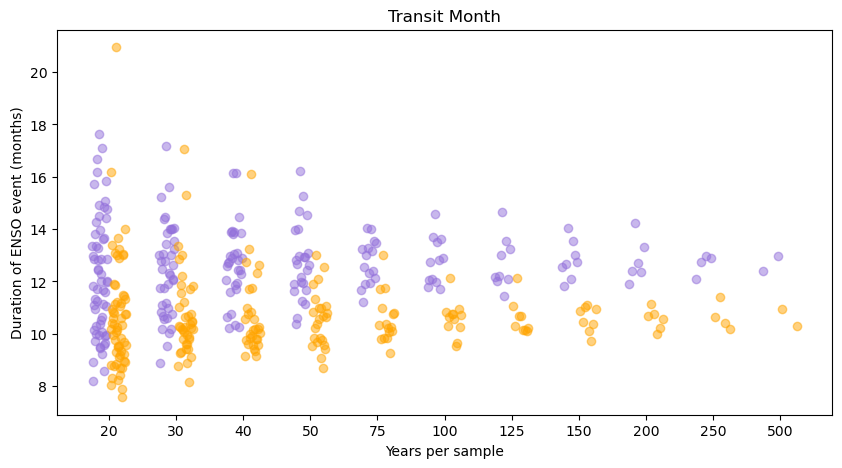

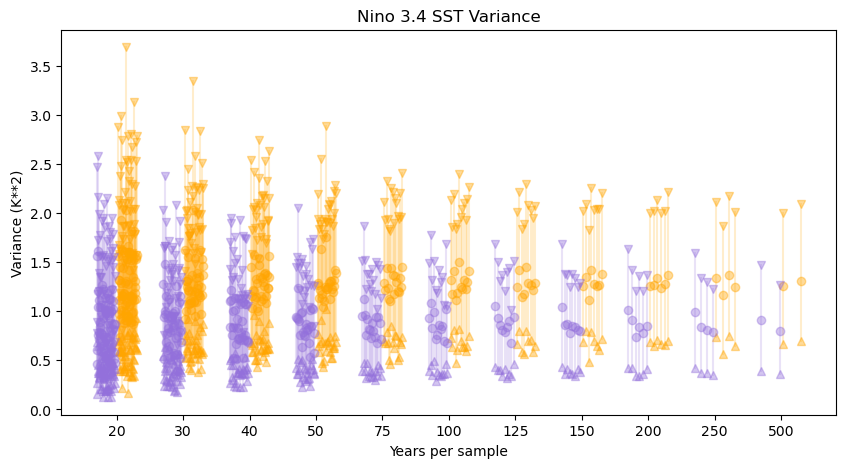

In [13]:
# sampleYears = np.arange(20, 210, 10)
sampleYears = [20, 30, 40, 50, 75, 100, 125, 150, 200, 250, 500] 
ticks = np.arange(len(sampleYears))*2

lat = DS_all_cesm1.lat.values
lon = DS_all_cesm1.lon.values

fig1,axs1 = plt.subplots(1,1,figsize=(10,5))
fig2,axs2 = plt.subplots(1,1,figsize=(10,5))

for iSample in range(len(sampleYears)):
# for iSample in range(3):
    
    n_spacing    = int(sampleYears[iSample])  ## this is used to create the .nc files! Above is just for testing
    nYearsPer    = int(sampleYears[iSample])
    nSamples     = int(np.floor(np.nanmin([((nYears_cesm1 - nYearsPer) // n_spacing + 1), ((nYears_cesm2 - nYearsPer) // n_spacing + 1)])) )
    print('Creating %i samples to compute ENSO over, starting every %i years and each with a window of %i years.' % (nSamples, n_spacing, nYearsPer))

    # Create an empty array to store the reshaped data
    events_cesm1 = np.zeros([nSamples, nYearsPer*12, len(DS_all_cesm1.lat.values), len(DS_all_cesm1.lon.values)])
    events_cesm2 = np.zeros([nSamples, nYearsPer*12, len(DS_all_cesm2.lat.values), len(DS_all_cesm2.lon.values)])
    
    ## Loop over the events and fill the new array
    lon0_cesm1 = np.full([nSamples], np.nan)
    lon0_cesm2 = np.full([nSamples], np.nan)
    lat0_cesm1 = np.full([nSamples], np.nan)
    lat0_cesm2 = np.full([nSamples], np.nan)
    lon0p5_cesm1 = np.full([nSamples], np.nan)
    lon0p5_cesm2 = np.full([nSamples], np.nan)
    lat0p5_cesm1 = np.full([nSamples], np.nan)
    lat0p5_cesm2 = np.full([nSamples], np.nan)
    nino34_var_cesm1 = np.full([nSamples,12], np.nan)
    nino34_var_cesm2 = np.full([nSamples,12], np.nan)
    nino34_ac_cesm1 = np.full([nSamples,48], np.nan)
    nino34_ac_cesm2 = np.full([nSamples,48], np.nan)
    transit_month_cesm1 = np.full([nSamples], np.nan)
    transit_month_cesm2 = np.full([nSamples], np.nan)
    
    for iENSO in range(nSamples):
        start_year = iENSO * (n_spacing*12)
        events_cesm1[iENSO, :, :,:] = DS_all_cesm1.TS.isel(time=slice(start_year, (start_year + nYearsPer*12)))
        events_cesm2[iENSO, :, :,:] = DS_all_cesm2.ts.isel(time=slice(start_year, (start_year + nYearsPer*12)))
        time_coords  = DS_all_cesm1.time.values[13400:(13400+(nYearsPer*12))]

        lon0_cesm1[iENSO], lat0_cesm1[iENSO], lon0p5_cesm1[iENSO], lat0p5_cesm1[iENSO], nino34_var_cesm1[iENSO,:], nino34_ac_cesm1[iENSO, :], transit_month_cesm1[iENSO] = get_ninoMetrics(events_cesm1[iENSO, :, :,:], time_coords, lat, lon)
        lon0_cesm2[iENSO], lat0_cesm2[iENSO], lon0p5_cesm2[iENSO], lat0p5_cesm2[iENSO], nino34_var_cesm2[iENSO,:], nino34_ac_cesm2[iENSO, :], transit_month_cesm2[iENSO] = get_ninoMetrics(events_cesm2[iENSO, :, :,:], time_coords, lat, lon)
    
    ## Plot duration (autocor transition month)
    offset_cesm1 = np.linspace(ticks[iSample]-0.5, ticks[iSample]-0.05, nSamples)
    offset_cesm2 = np.linspace(ticks[iSample]+0.05, ticks[iSample]+0.5, nSamples)
    axs1.plot(offset_cesm1, transit_month_cesm1, 'o', color='mediumpurple', alpha=0.5)
    axs1.plot(offset_cesm2, transit_month_cesm2, 'o', color='orange', alpha=0.5)

    ## Plot nino variances
    offset_cesm1 = np.linspace(ticks[iSample]-0.6, ticks[iSample]-0.05, nSamples)
    offset_cesm2 = np.linspace(ticks[iSample]+0.05, ticks[iSample]+0.6, nSamples)
    for iENSO in range(nSamples):
        ## CESM1
        case_max = np.nanmax(nino34_var_cesm1[iENSO,:])
        case_min = np.nanmin(nino34_var_cesm1[iENSO,:])
        # Weighted mean
        weights = ( daysPerMonth / daysPerMonth.sum() )
        weighted_mean = (nino34_var_cesm1[iENSO,:] * weights).sum() / weights.sum()

        axs2.plot(offset_cesm1[iENSO]*np.ones(2), [case_min, case_max],
                 '-', color='mediumpurple', alpha=0.2)
        axs2.plot(offset_cesm1[iENSO], weighted_mean,'o', color='mediumpurple',alpha=0.4)
        axs2.plot(offset_cesm1[iENSO], case_min,'^',color='mediumpurple',alpha=0.4)
        axs2.plot(offset_cesm1[iENSO],case_max,'v',color='mediumpurple',alpha=0.4)

        ## CESM2
        case_max = np.nanmax(nino34_var_cesm2[iENSO,:])
        case_min = np.nanmin(nino34_var_cesm2[iENSO,:])
        # Weighted mean
        weights = ( daysPerMonth / daysPerMonth.sum() )
        weighted_mean = (nino34_var_cesm2[iENSO,:] * weights).sum() / weights.sum()

        axs2.plot(offset_cesm2[iENSO]*np.ones(2), [case_min, case_max],
                 '-', color='orange', alpha=0.2)
        axs2.plot(offset_cesm2[iENSO], weighted_mean,'o', color='orange',alpha=0.4)
        axs2.plot(offset_cesm2[iENSO], case_min,'^',color='orange',alpha=0.4)
        axs2.plot(offset_cesm2[iENSO],case_max,'v',color='orange',alpha=0.4)

axs1.set_xticks(ticks)
axs1.set_xticklabels(np.array(sampleYears).astype(str))
axs1.set_title('Transit Month')
axs1.set_xlabel('Years per sample')
axs1.set_ylabel('Duration of ENSO event (months)')

axs2.set_xticks(ticks)
axs2.set_xticklabels(np.array(sampleYears).astype(str))
axs2.set_title('Nino 3.4 SST Variance')
axs2.set_xlabel('Years per sample')
axs2.set_ylabel('Variance (K**2)')


## What about using pieces of the large ensemble too? 
